# Lab 3: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1AAbsur4Cwn9SeBZ46pnriOi4TSKtKUbx?usp=sharing

In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import matplotlib.pyplot as plt

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

A) maximum age = 90; average age = 38.58164675532078; minimum age = 17

maximum yredu = 16; average yredu = 10.0806793403151; minimum yredu = 1

maximum capgain = 99999; average capgain = 1077.6488437087312; minimum capgain = 0

maximum caploss = 4356; average caploss = 87.303829734959; minimum caploss = 0

maximum workhr = 99; average workhr = 40.437455852092995; minimum workhr = 1

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [ ]:
#write code for minimum, maximum, average across dataset for each columm
column_headers = ["age","yredu","capgain","caploss","workhr"]
for column_header in column_headers:
    print("maximum", column_header,np.max(df[column_header]))
    print("average",column_header,np.average(df[column_header]))
    print("minimum", column_header,np.min(df[column_header]))

maximum age 90
average age 38.58164675532078
minimum age 17
maximum yredu 16
average yredu 10.0806793403151
minimum yredu 1
maximum capgain 99999
average capgain 1077.6488437087312
minimum capgain 0
maximum caploss 4356
average caploss 87.303829734959
minimum caploss 0
maximum workhr 99
average workhr 40.437455852092995
minimum workhr 1


In [ ]:
#write code to normalize dataset
for header in column_headers:
    df[header]=(df[header]-np.min(df[header]))/(np.max(df[header])-np.min(df[header]))
    print("maximum", header,np.max(df[header]))
    print("minimum", header,np.min(df[header]))

maximum age 1.0
minimum age 0.0
maximum yredu 1.0
minimum yredu 0.0
maximum capgain 1.0
minimum capgain 0.0
maximum caploss 1.0
minimum caploss 0.0
maximum workhr 1.0
minimum workhr 0.0


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

Male: 66.92260442260442%

Female: 33.08046683046683%

In [ ]:
percent_mal = sum(df["sex"] == " Male")/(df["sex"].shape[0]-1)  #-1 to account for column header row
print("percent male = ", percent_mal*100)

percent_fem = sum(df["sex"] == " Female")/(df["sex"].shape[0]-1)
print("percent female = ", percent_fem*100)

percent male =  66.92260442260442
percent female =  33.08046683046683


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

A) 1843 records were missing. This corresponded to 5.660145572924664% of records being removed.

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_missing = df[missing]
df_not_missing = df[~missing]

number_missing = float(df_missing.shape[0])
print("missing records = ", number_missing)
percent_removed = float(df_missing.shape[0])/(float(df_missing.shape[0])+float(df_not_missing.shape[0]))
print("% removed = ", percent_removed*100)

missing records =  1843.0
% removed =  5.660145572924664


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

A) {' Private', ' Local-gov', ' Self-emp-not-inc', ' Self-emp-inc', ' Without-pay', ' State-gov', ' Federal-gov'}

In [ ]:
print(set(df_not_missing["work"]))

{' Local-gov', ' Self-emp-not-inc', ' State-gov', ' Without-pay', ' Federal-gov', ' Self-emp-inc', ' Private'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

A) There are 57 columns in data. They comprise the original columns as well as the additional columns created for each sub-category of the original columns during one-hot encoding through the get_dummies function.

In [ ]:
shape = data.shape
print("num_columns =", shape[1])

num_columns = 57


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.
    ind=np.argmax(onehot)  #get index of the max value of one-hot encoding
    values = cat_values[feature]   #get values associated with the feature
    return values[ind] #return the apt value based on the index of max value of one-hot encoding

In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

A)
Items in training set =  21502

Items in validation set =  4608

Items in test set =  4608

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
from sklearn.model_selection import train_test_split

np.random.seed(50)

#Get training data
train_data, test_data = train_test_split(datanp, train_size = 0.7, random_state = 1)

#Get validation and testing data
val_data, test_data = train_test_split(test_data, test_size = 0.5, random_state = 1)

print("Items in training set = ", train_data.shape[0])
print("Items in validation set = ", val_data.shape[0])
print("Items in test set = ", test_data.shape[0])

Items in training set =  21502
Items in validation set =  4608
Items in test set =  4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 40), # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(40, 25)
        )
        self.decoder = nn.Sequential(
            nn.Linear(25, 40),
            nn.Linear(40, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

A) The input values stored in the data frame 'data' were normalized to be between 0 and 1, which means that we need the decoder's outputs to be between 0 and 1. The training code uses MSE as a loss, which exceeds the 0 to 1 range. The sigmoid activation ensures that our outputs will actually fall between 0 to 1.

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []
    epochs = []

    for epoch in range(num_epochs):
        epochs.append(epoch)
        epoch_train_loss = 0
        epoch_val_loss = 0
        i = 0
        j = 0
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_train_loss+=loss.detach().numpy()
            i+=1

        for data in val_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            epoch_val_loss+=loss.detach().numpy()
            j+=1

        train_acc.append(get_accuracy(model,train_loader))
        val_acc.append(get_accuracy(model,val_loader))

        train_loss.append(epoch_train_loss/(i+1))
        val_loss.append(epoch_val_loss/(j+1))

        print("epoch = ", epoch)
        print("training accuracy = ", train_acc[epoch])
        print("validation accuracy = ", val_acc[epoch],"\n")

    plt.title("Accuracy vs. Epochs")
    plt.plot(epochs,train_acc,label = "Training")
    plt.plot(epochs,val_acc, label = "Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc = 'best')
    plt.show()


    plt.title("Loss vs. Epochs")
    plt.plot(epochs,train_loss,label = "Training")
    plt.plot(epochs,val_loss,label = "Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc = 'best')
    plt.show()


### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

epoch =  0
training accuracy =  0.4588332868260317
validation accuracy =  0.45601851851851855 

epoch =  1
training accuracy =  0.5009844045515146
validation accuracy =  0.5026041666666666 

epoch =  2
training accuracy =  0.542546429789477
validation accuracy =  0.5440176504629629 

epoch =  3
training accuracy =  0.5629786376461104
validation accuracy =  0.5639467592592593 

epoch =  4
training accuracy =  0.5732800049607788
validation accuracy =  0.5740017361111112 



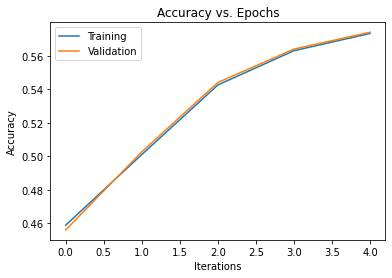

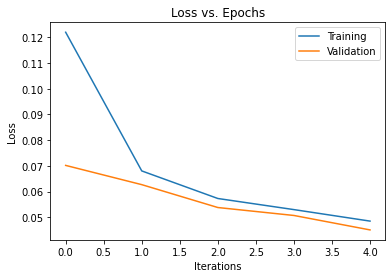

In [ ]:
batch_size = 32
num_epochs = 5
lr = 1e-4
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)
print(train_loader)

auto1 = AutoEncoder()
train(auto1, train_loader,val_loader, num_epochs, lr)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

A) My models had the following hyperparameters:

[batch_size, epochs, learning rate] = [64,5,1e-4], [32, 10, 1e-4], [32,10,1e-2], [32,30,1e-4]

I started by increasing batch size to 64 to reduce randomness in my gradient descent, but my validation accuracy reduced to 54% because of it. After that, I tried using my default batch size but increasing the number of epochs to allow the model to reach greater convergence given the increasing validation accuracy rate in my previous graphs. My validation accuracy improved to 62% with it. I then tried a larger learning rate to see if convergence could be attained in fewer epochs. The accuracy graphs oscillated a lot more without giving significant improvement in accuracies with a higher learning rate. So for my final model, I chose a batch size of 32 run over 10 epochs with a learning rate of 1e-4. It gave me a validation accuracy of 63%.

[64, 5, 0.0001]
epoch =  0
training accuracy =  0.45794189687780984
validation accuracy =  0.4564887152777778 

epoch =  1
training accuracy =  0.46539081635816826
validation accuracy =  0.46383101851851855 

epoch =  2
training accuracy =  0.4598099401606052
validation accuracy =  0.45826099537037035 

epoch =  3
training accuracy =  0.5083403094285803
validation accuracy =  0.509765625 

epoch =  4
training accuracy =  0.5389343626949431
validation accuracy =  0.5424623842592593 



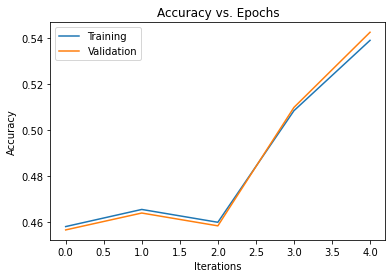

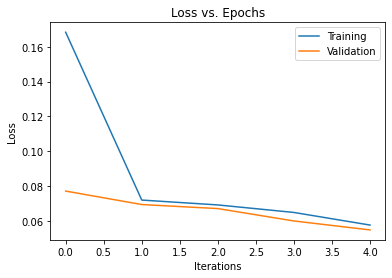

[32, 10, 0.0001]
epoch =  0
training accuracy =  0.45787213592534026
validation accuracy =  0.45522280092592593 

epoch =  1
training accuracy =  0.4733900722413419
validation accuracy =  0.47280092592592593 

epoch =  2
training accuracy =  0.5472901745574055
validation accuracy =  0.5479600694444444 

epoch =  3
training accuracy =  0.5613586333054289
validation accuracy =  0.5592809606481481 

epoch =  4
training accuracy =  0.5640328031500945
validation accuracy =  0.5618127893518519 

epoch =  5
training accuracy =  0.573814838929712
validation accuracy =  0.5730251736111112 

epoch =  6
training accuracy =  0.5857749666697671
validation accuracy =  0.5849609375 

epoch =  7
training accuracy =  0.5987039965274548
validation accuracy =  0.6006582754629629 

epoch =  8
training accuracy =  0.6109819241620934
validation accuracy =  0.6129557291666666 

epoch =  9
training accuracy =  0.6182215607850432
validation accuracy =  0.62109375 



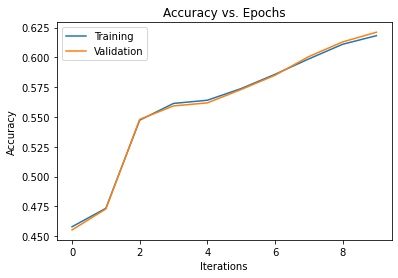

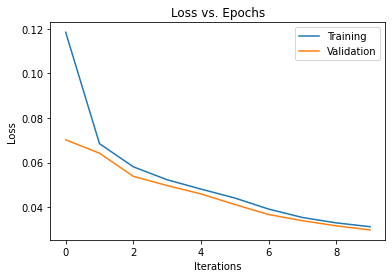

[32, 10, 0.01]
epoch =  0
training accuracy =  0.5962933680587852
validation accuracy =  0.5956307870370371 

epoch =  1
training accuracy =  0.6070443059560351
validation accuracy =  0.6043475115740741 

epoch =  2
training accuracy =  0.6025175952624562
validation accuracy =  0.6034794560185185 

epoch =  3
training accuracy =  0.5923557498527269
validation accuracy =  0.5923755787037037 

epoch =  4
training accuracy =  0.6172061513657644
validation accuracy =  0.6189959490740741 

epoch =  5
training accuracy =  0.5965104021331349
validation accuracy =  0.6001519097222222 

epoch =  6
training accuracy =  0.5773416426378941
validation accuracy =  0.5805844907407407 

epoch =  7
training accuracy =  0.5745046972374663
validation accuracy =  0.5731336805555556 

epoch =  8
training accuracy =  0.5662263975444145
validation accuracy =  0.5681423611111112 

epoch =  9
training accuracy =  0.5407558986760922
validation accuracy =  0.5408347800925926 



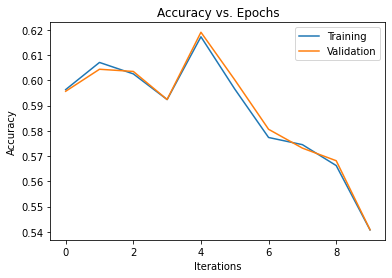

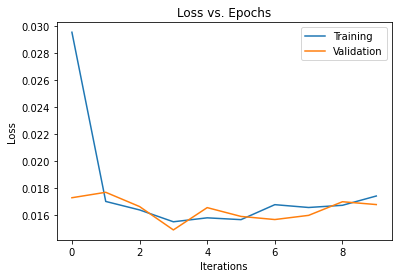

[32, 30, 0.0001]
epoch =  0
training accuracy =  0.46311970979443773
validation accuracy =  0.46198640046296297 

epoch =  1
training accuracy =  0.5083403094285803
validation accuracy =  0.5081018518518519 

epoch =  2
training accuracy =  0.5383065141227172
validation accuracy =  0.5391348379629629 

epoch =  3
training accuracy =  0.5574985272687812
validation accuracy =  0.5582682291666666 

epoch =  4
training accuracy =  0.5719235419960934
validation accuracy =  0.5706380208333334 

epoch =  5
training accuracy =  0.5780857594642359
validation accuracy =  0.5750506365740741 

epoch =  6
training accuracy =  0.5772718816854246
validation accuracy =  0.5749059606481481 

epoch =  7
training accuracy =  0.5895265556692401
validation accuracy =  0.5887948495370371 

epoch =  8
training accuracy =  0.6033779803429138
validation accuracy =  0.6020688657407407 

epoch =  9
training accuracy =  0.6120593433169007
validation accuracy =  0.6082899305555556 

epoch =  10
training accuracy =

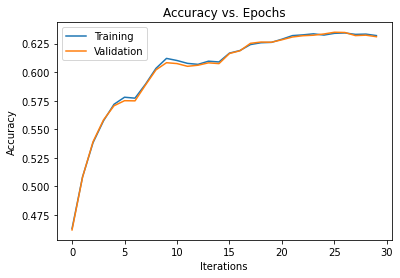

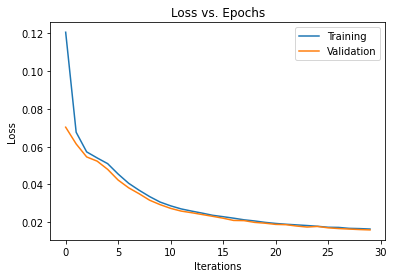

In [ ]:
hyp_models = [[64,5,1e-4],[32, 10, 1e-4],[32,10,1e-2],[32,30,1e-4]] #[batch size, epochs, learning rate]

for hyps in hyp_models:
  print(hyps)
  auto2 = AutoEncoder()
  train_loader = torch.utils.data.DataLoader(train_data, batch_size = hyps[0])
  val_loader = torch.utils.data.DataLoader(val_data, batch_size = hyps[0])
  test_loader = torch.utils.data.DataLoader(test_data, batch_size = hyps[0])
  train(auto2,train_loader,val_loader,hyps[1], hyps[2])



## Part 4. Testing [7 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

Test accuracy = 63.45847800925926%

In [ ]:
print("Test Accuracy = ", get_accuracy(auto2, test_loader))

Test Accuracy =  0.6345847800925926


### Part (b) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

A) The first item has the following features:
work : Private
marriage : Married-civ-spouse
occupation : Farming-fishing
edu : Some-college
relationship : Husband
sex : Male


Yes, I think a human can guess this education level for the corresponding features. I was a consultant for an agricultural company over my PEY and noted that many farmers had some college education in agriculture which they used in their farming practices. I can imagine that people in farming-fishing specifically might also need some expertise about marine life, which could be obtained from a college education, but may not need highly specific education like a university bachelors or masters/PhD.

In [ ]:
for header in catcols:
  value = get_categorical_value(get_onehot(test_data[0],header),header)
  print(header,":",value)

work : Private
marriage : Married-civ-spouse
occupation : Farming-fishing
edu : Some-college
relationship : Husband
sex : Male


### Part (c) [2 pt]

What is your model's prediction of this person's education
level, given their other features?

A) My model predicts that this person is a high school graduate, which seems reasonable given that farming-fishing can be done without education beyond high-school as well.

In [ ]:
test_data2 = test_data
input_array = zero_out_feature(test_data2,"edu")
input_tensor = torch.from_numpy(input_array)
prediction_tensor = auto2(input_tensor)
prediction_array = prediction_tensor.detach().numpy()

value = get_categorical_value(get_onehot(prediction_array[0],"edu"),"edu")
print("edu:",value)

[[0.1369863  0.6        0.         ... 0.         0.         1.        ]
 [0.30136988 0.6        0.         ... 0.         1.         0.        ]
 [0.32876712 0.53333336 0.         ... 0.         0.         1.        ]
 ...
 [0.5753425  0.53333336 0.         ... 0.         0.         1.        ]
 [0.05479452 0.6        0.         ... 0.         1.         0.        ]
 [0.5068493  0.8666667  0.         ... 0.         0.         1.        ]]
edu: HS-grad


### Part (d) [2 pt]

What is the baseline model's prediction
of this person's education level?

A) The baseline model also predicts that this person is a high school graduate.

In [ ]:
pred_baseline_edu = baseline(input_array)
value_baseline = get_categorical_value(get_onehot(pred_baseline_edu[0],"edu"),"edu")
print("edu = ", value_baseline)

edu =  HS-grad
